In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
import json

plt.style.use('seaborn-ticks')

C:\Users\danie\AppData\Local\Temp\ipykernel_26372\3641321588.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


# Merge all results

In [30]:
base_dir = "C:/Users/danie/Documents/tirocinio/NLP Bcn/Persona modulation/Jailbreak_LLM-main/merged_eval_results"
models = [
    'Llamantino3-8b/merged'
    ]
models_multi = []
for m in models:
    models_multi.append(m + '/5_samples')
models_multi


['Llamantino3-8b/merged/5_samples']

In [31]:
dfs = []
config_dfs = []
multi_sample_string='_sample_5'
adv_string = '_advbench'
adv_check=False
for model in models:
    if adv_check==False:
        adv_string=''
    vanilla = json.load(open(f'{base_dir}/{model}/greedy-only/{adv_string}_matching_only_summary.json', 'r'))
    default = json.load(open(f'{base_dir}/{model}/default-only/{adv_string}_matching_only_summary.json', 'r'))
    data = json.load(open(f'{base_dir}/{model}/exploited/{adv_string}_matching_only_summary.json', 'r'))
    data_cp = {'model': model, 'default': default['default'], 'greedy': vanilla['greedy']}
    config_cp = {'model': model}
    for (k,v) in data.items():
        if k != 'best_attack_config':
            data_cp[k] = v
        else:
            for kk, vv in v.items():
                config_cp[kk] = (list(vv.keys())[0].split('_')[1], list(vv.values())[0])
    dfs.append(pd.DataFrame([data_cp]))
    config_dfs.append(pd.DataFrame([config_cp]))
dfs = pd.concat(dfs)
dfs

,model,default,greedy,break_by_temp,break_by_topk,break_by_topp,break_by_all
0,Llamantino3-8b/merged,41,7,92,90,91,98


In [32]:
config_dfs = pd.concat([config_dfs[0].iloc[:,0], dfs['default'], dfs['greedy'], config_dfs[0].iloc[:,1], config_dfs[0].iloc[:,3], config_dfs[0].iloc[:,2]], axis=1)
config_dfs

,model,default,greedy,temp,topp,topk
0,Llamantino3-8b/merged,41,7,"(0.75, 51)","(0.75, 56)","(100, 48)"


In [5]:
config_dfs.columns = ['model', 'default', 'greedy', 'temp', 'topp', 'topk']
config_dfs

,model,default,greedy,temp,topp,topk
0,Llamantino3-8b/merged,41,7,"(0.75, 51)","(0.75, 56)","(100, 48)"


In [6]:
config_dfs['temp'] = config_dfs['temp'].apply(lambda x: x[1])
config_dfs['topk'] = config_dfs['topk'].apply(lambda x: x[1])
config_dfs['topp'] = config_dfs['topp'].apply(lambda x: x[1])

In [7]:
for col in config_dfs.columns:
    if col!='model':
        config_dfs[col] = pd.to_numeric(config_dfs[col], errors='ignore')

In [8]:
config_dfs

,model,default,greedy,temp,topp,topk
0,Llamantino3-8b/merged,41,7,51,56,48


In [9]:
dfs_multi = []
config_dfs_multi = []
for model in models_multi:
    if adv_check==False:
        adv_string=''
    vanilla = {'greedy':np.nan}
    data = json.load(open(f'{base_dir}/{model}/{multi_sample_string}{adv_string}_matching_only_summary.json', 'r'))
    data_cp = {'model': model, 'greedy': vanilla['greedy']}
    config_cp = {'model': model}
    for (k,v) in data.items():
        if k != 'best_attack_config':
            data_cp[k] = v
        else:
            for kk, vv in v.items():
                config_cp[kk] = (list(vv.keys())[0].split('_')[1], list(vv.values())[0])
    dfs_multi.append(pd.DataFrame([data_cp]))
    config_dfs_multi.append(pd.DataFrame([config_cp]))
dfs_multi = pd.concat(dfs_multi)
dfs_multi

,model,greedy,break_by_temp,break_by_topk,break_by_topp,break_by_all
0,Llamantino3-8b/merged/5_samples,NaN,99,98,99,100


In [10]:
config_dfs_multi = pd.concat(config_dfs_multi)
config_dfs_multi.rename(columns={'temp':'temp_5_samples'}, inplace=True)

In [11]:
config_dfs['temp_5_samples'] = config_dfs_multi['temp_5_samples']
config_dfs

,model,default,greedy,temp,topp,topk,temp_5_samples
0,Llamantino3-8b/merged,41,7,51,56,48,"(0.9, 90)"


In [12]:
config_dfs.to_csv('C:/Users/danie/Documents/tirocinio/NLP Bcn/Persona modulation/Jailbreak_LLM-main/aggregate_results/aggregate_results.csv')

In [13]:
config_dfs

,model,default,greedy,temp,topp,topk,temp_5_samples
0,Llamantino3-8b/merged,41,7,51,56,48,"(0.9, 90)"


In [14]:
config_dfs = config_dfs.reset_index()
config_dfs

,index,model,default,greedy,temp,topp,topk,temp_5_samples
0,0,Llamantino3-8b/merged,41,7,51,56,48,"(0.9, 90)"


In [15]:
config_dfs.drop('index', axis=1, inplace=True)
config_dfs

,model,default,greedy,temp,topp,topk,temp_5_samples
0,Llamantino3-8b/merged,41,7,51,56,48,"(0.9, 90)"


In [20]:
# Extract the attack success rates from the tuples
config_dfs['temp_rate'] = config_dfs['temp']# .apply(lambda x: x[1])
config_dfs['topk_rate'] = config_dfs['topk']# .apply(lambda x: x[1])
config_dfs['topp_rate'] = config_dfs['topp']# .apply(lambda x: x[1])
config_dfs['temp_5_samples_rate'] = config_dfs['temp_5_samples'].apply(lambda x: x[1])



In [17]:
config_dfs['temp_5_samples_rate'] = config_dfs['temp_5_samples'].apply(lambda x: x[1])

In [21]:
config_dfs

,model,default,greedy,temp,topp,topk,temp_5_samples,temp_5_samples_rate,temp_rate,topk_rate,topp_rate
0,Llamantino3-8b/merged,41,7,51,56,48,"(0.9, 90)",90,51,48,56


In [22]:
type(config_dfs['temp_rate'][0])

numpy.int64

In [23]:
for col in config_dfs.columns:
    if col!='model':
        config_dfs[col] = pd.to_numeric(config_dfs[col], errors='ignore')

<Figure size 1200x600 with 0 Axes>

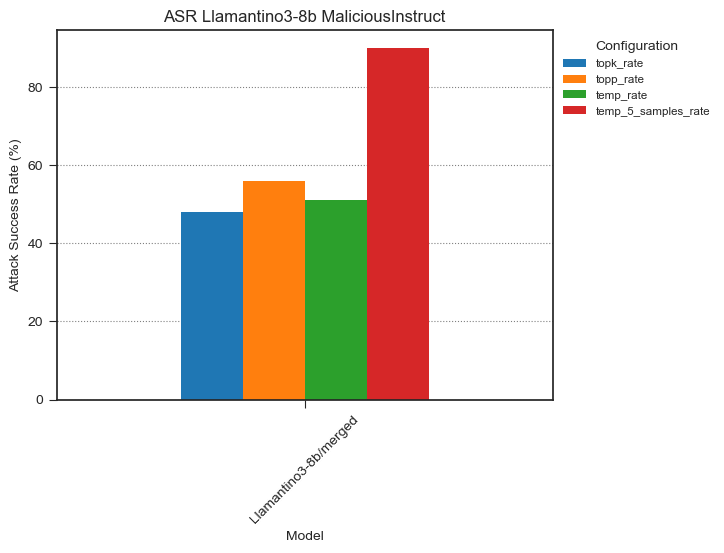

In [28]:
# Plotting
plt.figure(figsize=(12, 6))
config_dfs.plot(x='model', y=['topk_rate', 'topp_rate', 'temp_rate', 'temp_5_samples_rate'], kind='bar')
plt.title('ASR Llamantino3-8b MaliciousInstruct')
plt.xlabel('Model')
plt.ylabel('Attack Success Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle=':', color='gray', linewidth=0.8)
plt.legend(title='Configuration', bbox_to_anchor=(1, 1), fontsize='small')
# plt.tight_layout()
plt.show()

In [34]:
adv_string = '_advbench'
adv_check=True
dfs=pd.Series()
for model in models:
    if adv_check==False:
        adv_string=''
    data = pd.read_csv(f'{base_dir}/{model}/exploited/{adv_string}_matching_only_results.csv')
    data.drop('Unnamed: 0', axis=1, inplace=True)
    temp_data = data.filter(like='topk', axis=1)
    column_sums = temp_data.sum()
    dfs = pd.concat([dfs, column_sums], axis=1)

C:\Users\danie\AppData\Local\Temp\ipykernel_26372\422343708.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfs=pd.Series()


In [35]:
dfs = dfs.iloc[:,1:]
dfs.columns = models
dfs = dfs.reset_index()
dfs.rename(columns={'index':'Top_k'}, inplace=True)
dfs

,Top_k,Llamantino3-8b/merged
0,topk_1,42
1,topk_2,43
2,topk_5,33
3,topk_10,37
4,topk_20,47
5,topk_50,47
6,topk_100,40
7,topk_200,39


<Figure size 800x600 with 0 Axes>

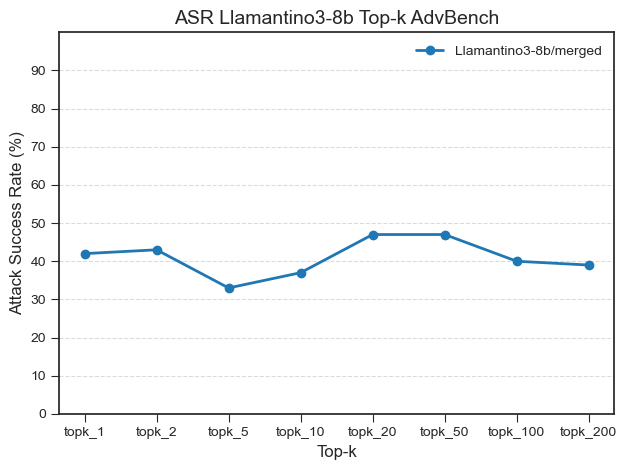

In [37]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
dfs.plot(x="Top_k", y=[col for col in models], marker='o', linestyle='-', linewidth=2)

# Add titles and labels
plt.title('ASR Llamantino3-8b Top-k AdvBench', fontsize=14)
plt.xlabel('Top-k', fontsize=12)
plt.ylabel('Attack Success Rate (%)', fontsize=12)

# Customize the grid and ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(range(0, column_sums.max() + 1), fontsize=10)
plt.ylim(0,100)
plt.yticks(range(0,100,10))

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
deltas_df = pd.DataFrame.from_dict(deltas_dict, orient='index', columns=['Delta temp', 'Delta top_p', 'Delta top_k'])
deltas_df


NameError: name 'deltas_dict' is not defined

In [ ]:
# Reset the index to have the temperatures as a column
deltas_df.reset_index(inplace=True)
deltas_df.rename(columns={'index': 'Model'}, inplace=True)

<Figure size 1000x600 with 0 Axes>

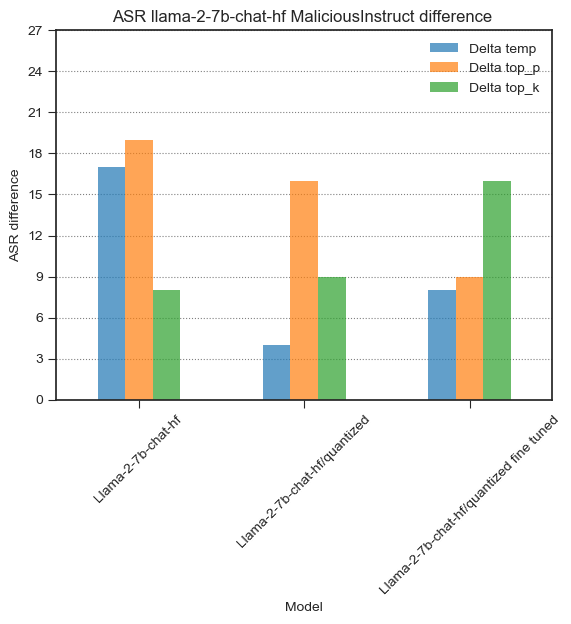

In [ ]:
plt.figure(figsize=(10, 6))
deltas_df.plot(x='Model', y=['Delta temp', 'Delta top_p', 'Delta top_k'], alpha=0.7, kind='bar')
plt.yticks(range(0,30,3))
plt.grid(axis='y', linestyle=':', color='gray', linewidth=0.8)
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('ASR difference')
plt.title('ASR llama-2-7b-chat-hf MaliciousInstruct difference ')
plt.legend()